<a href="https://colab.research.google.com/github/wgcv/Style-Transfer-with-Deep-Learning/blob/master/Transfer_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer style

This Notebook is based on the paper [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) and Programa Nanodegree PyTorch Scholarship Challenge of Udacity.
 This paper talk about how to use the 19-layer VGG Network to extrack the style from one imagen and the conent for the other, passing the style to the content. The 19-layer VGG is a series of convultion network and pooling with fully connected layers.

## The style

## Oswaldo Guayasamīn
For this event we are going to use a traditional ecuatorian artis: **Oswaldo Guayasamín** (July 6, 1919 – March 10, 1999) was an Ecuadorian master painter and sculptor of Quechua and Mestizo heritage.[wikipedia](https://en.wikipedia.org/wiki/Oswaldo_Guayasam%C3%ADn)



## Paintings
### Ternura
![Ternura](https://i.pinimg.com/236x/bb/1a/f2/bb1af2dcf3a007ccec91760751d0d264--quito-ecuador-art-gallery.jpg)
### El Tiempo
![El Tiempo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTxse7mDiZwFXMIu3m3UTRDnOwD5pmSUl4PMWVK8xDzU71QwOvUTw)
### Desconfianza
![Desconfianza](http://4.bp.blogspot.com/-ERgRNRy3vc8/UPbIXFXj-0I/AAAAAAAAAZM/Jc3worp63xI/s1600/Guayasamin.jpg)

## Requierments

In [0]:
# Install PyTorch in Google Colab
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
# Install Pillow 5.3.0
!pip install -U pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (5.3.0)
5.3.0


## Import resources

In [0]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load the VGG19 Model
The VGG19 have to part one is the feature (Where we are going to extract the style) and the classifier that predict what image is.

In [0]:
# get the "features" portion of VGG19
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [35]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Content and Style Features

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1', ## Style representation
                  '5': 'conv2_1', ## Style representation
                  '10': 'conv3_1', ## Style representation
                  '19': 'conv4_1', ## Style representation
                  '21': 'conv4_2', ## content representation
                  '28': 'conv5_1', ## Style representation
                 }
        
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Gram Matrix

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    barch_size, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [39]:
## This is only for get acces to the google Drive if you are working with google Colab
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [0]:
# load in content and style image
content = load_image('images/cheshire.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/guayasamin.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## The images
The content is a picture of [@sashitsu ](https://www.instagram.com/sashitsu/) is Cheshire the cat of Alicia in the Wonderland, you can check the original [picture](https://www.instagram.com/p/Ba_EQHZhR0O/)

The Style is from Guayasamin, the picture 'Ternura' 


Our images


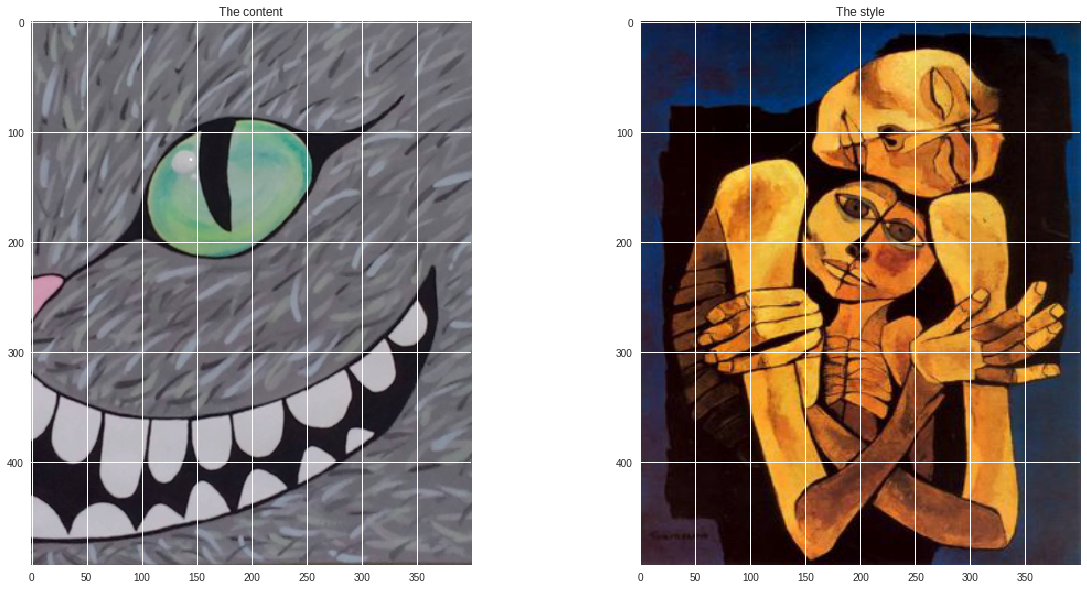

In [42]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("The content")
ax2.imshow(im_convert(style))
ax2.set_title("The style")
print('Our images')

In [0]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Loss and Weights

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
style_weights = {'conv1_1': 0.5,
                 'conv2_1': 0.3,
                 'conv3_1': 0.7,
                 'conv4_1': 0.8,
                 'conv5_1': 1.0}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

Total loss:  28206978.0


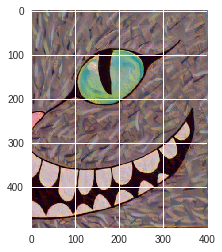

Total loss:  12260562.0


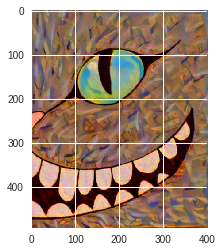

Total loss:  5256467.5


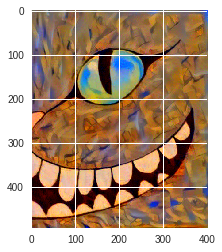

Total loss:  3710059.75


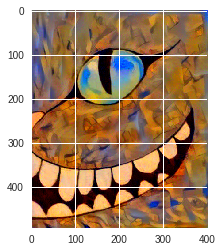

Total loss:  2872278.75


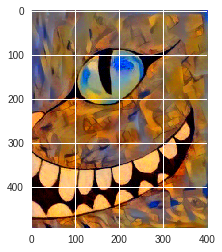

Total loss:  2247750.25


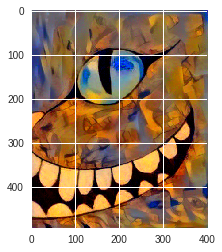

Total loss:  1725776.75


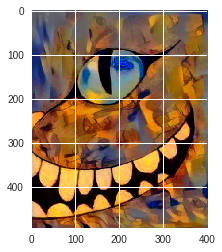

Total loss:  1257890.25


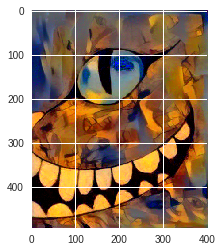

Total loss:  876188.125


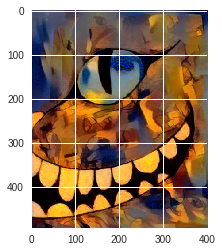

Total loss:  624397.25


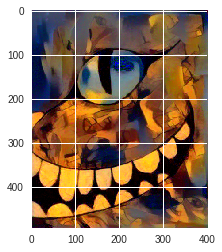

In [45]:
# for displaying the target image, intermittently
show_every = 600

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 6000

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Show the results

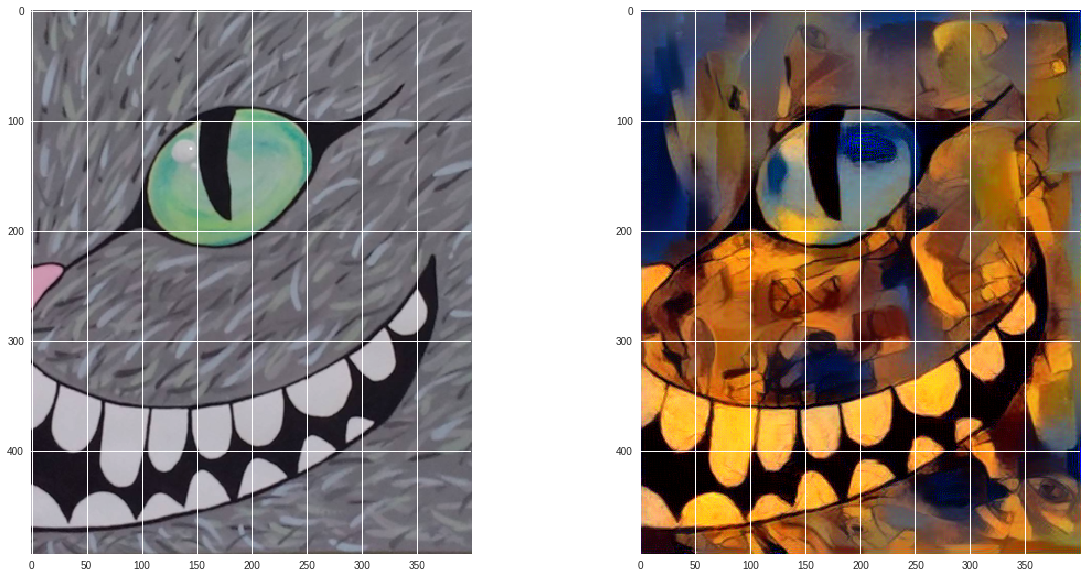

In [48]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

## Save the image

In [0]:
rescaled = (255.0 / im_convert(target).max() * (im_convert(target) - im_convert(target).min())).astype(np.uint8)

im = Image.fromarray(rescaled)
im.save('images/cat_guayasamin.jpg', 'JPEG')
